# Import Custom Attention Layer

In [1]:
import os
os.chdir('C:/Users/kbhandari/OneDrive - Epsilon/Desktop/Not Just OLS/LSTM/Text Summarization')
from attention import AttentionLayer

# Import all libraries

In [2]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Read the dataset

In [3]:
data = pd.read_csv('flipkart_com-ecommerce_sample.csv')
data = data[['product_name','description']]
data.columns = ['Summary', 'Text']
data.replace("", float("NaN"), inplace=True)

#dropping duplicates
data.drop_duplicates(subset=['Text'],inplace=True)
#dropping na
data.dropna(axis=0,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17539 entries, 0 to 19976
Data columns (total 2 columns):
Summary    17539 non-null object
Text       17539 non-null object
dtypes: object(2)
memory usage: 411.1+ KB


# Preprocessing

In [4]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text, remove_stopwords = True):
    cleanedString = text.lower() #Convert everything to lowercase
    cleanedString = re.sub(r'\([^)]*\)', '', cleanedString) 
    cleanedString = re.sub('"','', cleanedString) #Replace double quotes   
    cleanedString = re.sub(r"'s\b","",cleanedString) #Remove (‘s)
    cleanedString = re.sub("[^a-zA-Z]", " ", cleanedString) #Eliminate punctuations and special characters
    if remove_stopwords:
        tokens = [w for w in cleanedString.split() if not w in stop_words] #Remove stopwords
    else:
        tokens=cleanedString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:   #Remove short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [5]:
#Calling the function on Source
cleaned_source = []
for t in data['Text']:
    cleaned_source.append(text_cleaner(t, remove_stopwords = True))
    
print(cleaned_source[:5])

['key features alisha solid women cycling shorts cotton lycra navy red navy specifications alisha solid women cycling shorts shorts details number contents sales package pack fabric cotton lycra type cycling shorts general details pattern solid ideal women fabric care gentle machine wash lukewarm water bleach additional details style code altht box shorts', 'fabhomedecor fabric double sofa bed price rs fine deep seating experience save space new click clack sofa bed easy fold vice versa simple click clack mechanism chrome legs mango wood frame long term durability double cushioned sofa bed provide extra softness make fine seating experience double bed easily sleep two specifications fabhomedecor fabric double sofa bed installation demo installation demo details installation demo product done free cost part purchase service partner visit location within business hours delivery product box sofa bed general brand fabhomedecor mattress included delivery condition knock storage included mec

In [6]:
#Calling the function on Target
cleaned_target = []
for t in data['Summary']:
    cleaned_target.append(text_cleaner(t, remove_stopwords = False))

print(cleaned_target[:5])

['alisha solid women cycling shorts', 'fabhomedecor fabric double sofa bed', 'aw bellies', 'alisha solid women cycling shorts', 'sicons all purpose arnica dog shampoo']


In [7]:
data['cleaned_source']=cleaned_source
data['cleaned_target']=cleaned_target

# Drop Empty Rows

In [8]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
print(data.shape)

(17539, 4)


# EDA on Text Sequences
Here, we will analyze the length of the source and the target to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

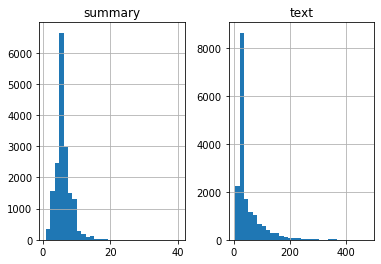

In [10]:
source_word_count = []
target_word_count = []

# Appending sequence lengths to the lists
for i in data['cleaned_source']:
      source_word_count.append(len(i.split()))

for i in data['cleaned_target']:
      target_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':source_word_count, 'summary':target_word_count})

length_df.hist(bins = 30)
plt.show()

Let us understand what percentage of source and target sequences fall below 100 and 20 respectively. This will help us understand where to cap the sequence length.

In [11]:
cnt=0
for i in data['cleaned_source']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(data['cleaned_source']))

0.8819202919208621


In [12]:
cnt=0
for i in data['cleaned_target']:
    if(len(i.split())<=20):
        cnt=cnt+1
print(cnt/len(data['cleaned_target']))

0.9992017788927533


We can fix the maximum length of the target to 20 since that seems to capture majority of the words in the sequence.
For the source sequence length, we can fix that to 100 as it captures 88% of the total sequences in the dataset.

In [13]:
max_source_len=100
max_target_len=20

Let us select the source and target sentences whose length is less than or equal to **max_source_len** and **max_target_len**.

In [14]:
cleaned_source = np.array(data['cleaned_source'])
cleaned_target = np.array(data['cleaned_target'])

short_source=[]
short_target=[]

for i in range(len(cleaned_source)):
    if(len(cleaned_target[i].split())<=max_target_len and len(cleaned_source[i].split())<=max_source_len):
        short_source.append(cleaned_source[i])
        short_target.append(cleaned_target[i])
        
df=pd.DataFrame({'source':short_source,'target':short_target})

Now, we add the **start** and **end** special tokens at the beginning and end of the target sentence. Note, this is only for the target sequence, not for the source sequence.

In [15]:
df['target'] = df['target'].apply(lambda x : 'start '+ x + ' end')

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df['source'].values, df['target'].values,
                                               test_size=0.1, random_state=123, shuffle=True)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(13918,) (13918,)
(1547,) (1547,)


# Source Text Tokenizer

In [17]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#Tokenize source words in training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

#Convert text sequences into integer sequences
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#Padding with zero upto maximum length
x_train = pad_sequences(x_train_seq,  maxlen=max_source_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_source_len, padding='post')

#Size of vocabulary (+1 for padding token)
x_vocab = len(x_tokenizer.word_index) + 1
print(x_vocab)

13880


# Target Text Tokenizer

In [18]:
#Tokenize target words in training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

#Convert text sequences into integer sequences
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

#Padding with zero upto maximum length
y_train = pad_sequences(y_train_seq, maxlen=max_target_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_target_len, padding='post')

#Size of vocabulary (+1 for padding token)
y_vocab = len(y_tokenizer.word_index) +1
print(y_vocab)

8313


# Model Build
Here, we are building a 3 stacked LSTM for the encoder:

In [19]:
from keras import backend as K 
K.clear_session()

latent_dim = max_source_len
embedding_dim=50
epochs = 100

# Encoder
encoder_inputs = Input(shape=(max_source_len,))

#embedding layer
enc_emb =  Embedding(x_vocab, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.3,recurrent_dropout=0.3)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_vocab, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 50)      694000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 100), ( 60400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [20]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,
                  validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
                  epochs=epochs, callbacks=[es], batch_size=128)

Train on 13918 samples, validate on 1547 samples
Epoch 1/100
13918/13918 [==============================] - 251s 18ms/sample - loss: 2.9056 - val_loss: 2.1001
Epoch 2/100
13918/13918 [==============================] - 278s 20ms/sample - loss: 2.1535 - val_loss: 1.8701
Epoch 3/100
13918/13918 [==============================] - 292s 21ms/sample - loss: 1.9388 - val_loss: 1.7242
Epoch 4/100
13918/13918 [==============================] - 296s 21ms/sample - loss: 1.7957 - val_loss: 1.5909
Epoch 5/100
13918/13918 [==============================] - 289s 21ms/sample - loss: 1.6779 - val_loss: 1.4988
Epoch 6/100
13918/13918 [==============================] - 288s 21ms/sample - loss: 1.5792 - val_loss: 1.4162
Epoch 7/100
13918/13918 [==============================] - 290s 21ms/sample - loss: 1.4960 - val_loss: 1.3426
Epoch 8/100
13918/13918 [==============================] - 292s 21ms/sample - loss: 1.4281 - val_loss: 1.2905
Epoch 9/100
13918/13918 [==============================] - 301s 22ms/sa

# Diagnostic plot

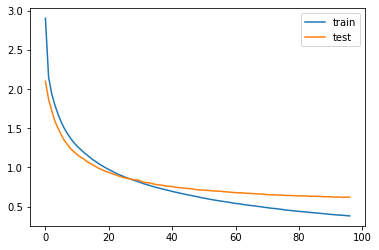

In [21]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now let’s build the dictionary to convert the index to word for target and source vocabulary:

In [22]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference
Set up the inference for the encoder and decoder:

In [23]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_source_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process:

In [24]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_target_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Here are a few summaries generated by the model on our validation dataset:

In [25]:
def seq_to_target(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq_to_source(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

for i in range(0,50):
    print("Source Sentence:",seq_to_source(x_val[i]))
    print("Original Target:",seq_to_target(y_val[i]))
    print("Predicted Target:",decode_sequence(x_val[i].reshape(1,max_source_len)))
    print("\n")

Source Sentence: buy allure auto cm car mat hyundai sonata embera rs online allure auto cm car mat hyundai sonata embera best prices free shipping cash delivery genuine products day replacement guarantee 
Original Target: allure auto cm car mat hyundai sonata embera 
Predicted Target:  allure auto cm car mat maruti gypsy


Source Sentence: buy handicrafts showpiece cm rs online handicrafts showpiece cm best prices free shipping cash delivery genuine products day replacement guarantee 
Original Target: handicrafts showpiece cm 
Predicted Target:  handicrafts showpiece cm


Source Sentence: cotonex blue pink cotton kitchen linen set price rs reviews cotonex pure cotton glove specifications cotonex blue pink cotton kitchen linen set general brand cotonex design code kls material cotton style code kls pattern striped design stripe design color blue pink dimensions weight additional features fabric care machine washable dry clean bleach box number contents sales package pack sales package g